In [1]:
#As always, we import everything
import pandas as pd
import numpy as np 

import os
import re

import seaborn as sns

import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = './' + 'data'

# README

In [3]:
# Load the dataframes

year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')

train_lyrics_dataframe = pd.read_csv(data_dir + '/train_lyrics.csv').drop('Unnamed: 0', axis = 1)
msd_lyrics_dataframe = pd.read_csv(data_dir + '/msd_lyrics.csv').drop('Unnamed: 0', axis = 1)

msd_lyrics = msd_lyrics_dataframe['Lyrics']

train_lyrics = train_lyrics_dataframe['Lyrics']

frames = [train_lyrics, msd_lyrics]

final_lyrics = pd.concat(frames).reset_index().drop('index', axis = 1)

In [4]:
final_lyrics = final_lyrics.dropna().reset_index().drop('index',axis=1)

In [5]:
final_lyrics.head()

,Lyrics
0,Red One Sugababes Girls bring the fun of life ...
1,I guess it was yourself you were involved with...
2,Bill collectors at my door What can you do for...
3,I ain't cooking all day (I ain't your mama!) I...
4,All hands on deck All in front all in the back...


In [6]:
def label_lyrics (row):
    if row['labels'] == 1 :
        return 'Feminist'
    elif row['labels'] == 0:
        return 'Neutral'
    else :
        return 'Sexist'


train_lyrics_dataframe['Category'] = train_lyrics_dataframe.apply(label_lyrics, axis=1)

col = ['Category', 'Lyrics']
train_lyrics_dataframe = train_lyrics_dataframe[col]
train_lyrics_dataframe.head()

,Category,Lyrics
0,Feminist,Red One Sugababes Girls bring the fun of life ...
1,Feminist,I guess it was yourself you were involved with...
2,Feminist,Bill collectors at my door What can you do for...
3,Feminist,I ain't cooking all day (I ain't your mama!) I...
4,Feminist,All hands on deck All in front all in the back...


In [7]:
train_lyrics_dataframe.columns = ['Category', 'Lyrics']
train_lyrics_dataframe['category_id'] = train_lyrics_dataframe['Category'].factorize()[0]
category_id_df = train_lyrics_dataframe[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
print(id_to_category)
train_lyrics_dataframe.head()


{'Feminist': 0, 'Sexist': 1, 'Neutral': 2}
{0: 'Feminist', 1: 'Sexist', 2: 'Neutral'}


,Category,Lyrics,category_id
0,Feminist,Red One Sugababes Girls bring the fun of life ...,0
1,Feminist,I guess it was yourself you were involved with...,0
2,Feminist,Bill collectors at my door What can you do for...,0
3,Feminist,I ain't cooking all day (I ain't your mama!) I...,0
4,Feminist,All hands on deck All in front all in the back...,0


In [8]:
# create array of unigrams and bigrams features to 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_train = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(final_lyrics.Lyrics).toarray()
features_train = tfidf_train.fit_transform(train_lyrics_dataframe.Lyrics).toarray()
labels = train_lyrics_dataframe.category_id


In [9]:
features_train.shape

(532, 8408)

In [10]:
N = 10
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features_train, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_train.get_feature_names())[indices]
    print(feature_names)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


['mind guess' 'gimme' 'mean love' ... 'woman' 'boys' 'girls']
# 'Feminist':
  . Most correlated unigrams:
. worth
. stronger
. uh
. fix
. river
. mess
. respect
. woman
. boys
. girls
  . Most correlated bigrams:
. lady lady
. uh huh
. man loves
. uh uh
. way don
. oh girls
. pretty girl
. girl like
. woman woman
. yes yes
['oh gonna' 'world oh' 'weird' ... 'girls' 'girl' 'river']
# 'Neutral':
  . Most correlated unigrams:
. em
. remember
. dah
. singing
. lord
. wanna
. bitch
. girls
. girl
. river
  . Most correlated bigrams:
. remember remember
. doo doo
. oh stand
. yes want
. waiting moment
. come river
. jammin jammin
. dah dah
. peace mind
. oh lord
['moonlight' 'beat' 'walkin like' ... 'nigga' 'make love' 'dick']
# 'Sexist':
  . Most correlated unigrams:
. bitches
. baby
. body
. butt
. ass
. fuck
. bitch
. pussy
. nigga
. dick
  . Most correlated bigrams:
. let lick
. baby don
. leave em
. make baby
. baby tell
. love way
. baby wanna
. know want
. baby night
. make love


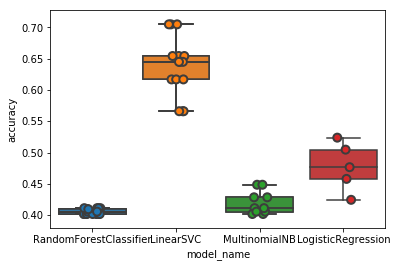

In [11]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
    
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features[0:532], labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.637337
LogisticRegression        0.477518
MultinomialNB             0.419183
RandomForestClassifier    0.406027
Name: accuracy, dtype: float64

0.7663551401869159


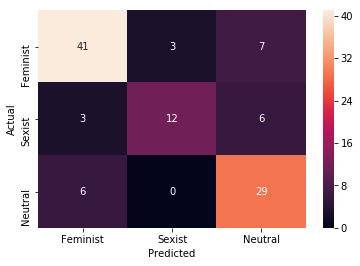

In [13]:
model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(features[0:532], labels, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = 0
for i, j in zip(y_test, y_pred):
    if (i == j):
        acc += 1

print(acc/len(y_test))
        
conf_mat = confusion_matrix(y_test, y_pred)
#fig, ax = plt.subplot()#figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
print(metrics.classification_report(y_test, y_pred, target_names=train_lyrics_dataframe['Category'].unique()))

              precision    recall  f1-score   support

    Feminist       0.82      0.80      0.81        51
      Sexist       0.80      0.57      0.67        21
     Neutral       0.69      0.83      0.75        35

   micro avg       0.77      0.77      0.77       107
   macro avg       0.77      0.73      0.74       107
weighted avg       0.77      0.77      0.76       107



In [16]:
model.fit(features[0:532], labels)
N = 10
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    print(indices.shape)
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

(442653,)
# 'Feminist':
  . Top unigrams:
       . girls
       . woman
       . boys
       . uh
       . cause
       . say
       . ladies
       . respect
       . mess
       . girl
  . Top bigrams:
       . don need
       . oh girls
       . woman woman
       . uh uh
       . girls wanna
       . yes yes
       . don wanna
       . uh huh
       . lady lady
       . pretend dead
(442653,)
# 'Neutral':
  . Top unigrams:
       . remember
       . river
       . dah
       . child
       . lord
       . singing
       . blue
       . jammin
       . somebody
       . soul
  . Top bigrams:
       . jammin jammin
       . dah dah
       . la la
       . want yeah
       . peace mind
       . somebody loved
       . day lovely
       . road jack
       . saints marching
       . softly leave
(442653,)
# 'Sexist':
  . Top unigrams:
       . baby
       . bitch
       . girl
       . body
       . wanna
       . butt
       . pussy
       . night
       . dick
       . ass
  . Top big

In [ ]:
# Uncomment this if you want to predict again

# DANGER ! May kill your kernel if you don't have enough memory

# y_pred = model.predict(features[532:])

In [18]:
temp = open( data_dir + "/all_y_preds.txt", "r")
y_pred = temp.read().split('\n')[:-1] # splitting by new line means last element is new line 


y_pred = [elem[:5] for elem in y_pred]
y_pred = list(map(float, y_pred))
y_pred = list(map(int, y_pred))
y_pred[0:5]

# y_pred = labels.append(y_pred)

len(y_pred)

51343

In [19]:
msd_lyrics_dataframe['labels'] = y_pred

msd_lyrics_dataframe['Class'] = msd_lyrics_dataframe.apply(label_lyrics, axis=1)

msd_lyrics_dataframe.head()

,Artists,Titles,Lyrics,labels,Class
0,albert king,can't you see what you're doing to me,Hey baby can't you see what you're doin' to me...,-1,Sexist
1,ann peebles,i still love you,Baby I'm feeling sort of lonely I heard the ne...,-1,Sexist
2,atomic rooster,and so to bed,Want Me Take Me Need Me -It's All In Your Mind...,0,Neutral
3,atomic rooster,banstead,Crane-Palmer-Graham Please take me out of this...,1,Feminist
4,bad company,can't get enough,One Two One Two Three Well I take whatever I w...,0,Neutral


In [22]:
Final_with_track_id = pd.merge(year_artist_name_title_genre, msd_lyrics_dataframe,  how='inner', left_on=['artist_name','title'], 
                 right_on = ['Artists','Titles'])
Final_with_track_id.head()

,year,artist_name,title,genre,Artists,Titles,Lyrics,labels,Class
0,1970,albert king,can't you see what you're doing to me,Blues,albert king,can't you see what you're doing to me,Hey baby can't you see what you're doin' to me...,-1,Sexist
1,1970,ann peebles,i still love you,RnB,ann peebles,i still love you,Baby I'm feeling sort of lonely I heard the ne...,-1,Sexist
2,1970,atomic rooster,and so to bed,Rock,atomic rooster,and so to bed,Want Me Take Me Need Me -It's All In Your Mind...,0,Neutral
3,1970,atomic rooster,and so to bed,Rock,atomic rooster,and so to bed,Want Me Take Me Need Me -It's All In Your Mind...,0,Neutral
4,1970,atomic rooster,banstead,Rock,atomic rooster,banstead,Crane-Palmer-Graham Please take me out of this...,1,Feminist


In [23]:
Final_with_track_id = Final_with_track_id.drop(columns=['Artists','Titles', 'Lyrics'])#,inplace=True)
Final_with_track_id.shape

(51767, 6)

In [24]:
Final_with_track_id.to_csv('Final_With_Track_ID.csv')